In [ ]:
import sys
sys.path.insert(0, '..')

In [ ]:
from IPython.display import Image
%matplotlib inline

In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [ ]:
X = ((X / 255.) - .5) * 2

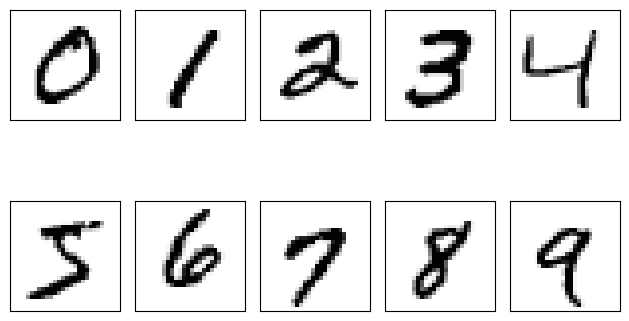

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

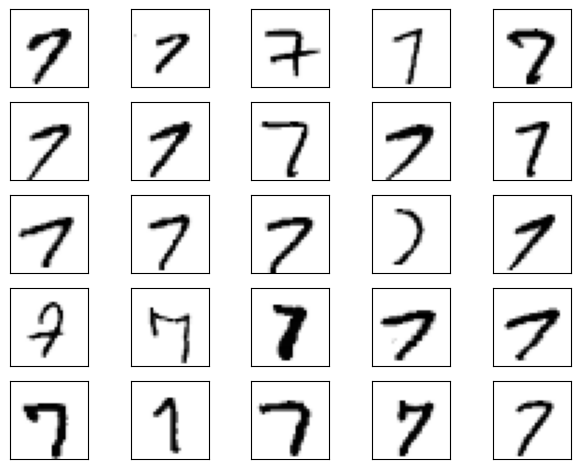

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 70% training and 30% testing
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# Optional: Further split training data into training (85% of 70%) and validation (15% of 70%)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=123, stratify=y_temp
)

# Optional: Free up memory by deleting unused arrays
del X_temp, y_temp, X, y


In [ ]:
import numpy as np

In [ ]:
## MODEL


def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # Initialize weights for two hidden layers
        rng = np.random.RandomState(random_seed)

        # Hidden layer 1
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # Hidden layer 2
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # Output layer
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer 1
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        # One-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        #########################
        ### Output layer weights
        #########################
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)  # sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # Gradients for output weights
        d_z_out__d_w_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__d_w_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################
        ### Hidden layer 2 weights
        #################################
        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        d_z_h2__d_w_h2 = a_h1
        d_loss__dw_h2 = np.dot(delta_h2.T, d_z_h2__d_w_h2)
        d_loss__db_h2 = np.sum(delta_h2, axis=0)

        #################################
        ### Hidden layer 1 weights
        #################################
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

        d_z_h1__d_w_h1 = x
        d_loss__dw_h1 = np.dot(delta_h1.T, d_z_h1__d_w_h1)
        d_loss__db_h1 = np.sum(delta_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__dw_h2, d_loss__db_h2,
                d_loss__dw_h1, d_loss__db_h1)


In [ ]:
model = NeuralNetMLP(
    num_features=28*28,
    num_hidden1=50,   # First hidden layer size
    num_hidden2=50,   # Second hidden layer size
    num_classes=10    # Output layer size (e.g., 10 for MNIST digits)
)

In [ ]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [ ]:


def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


# Forward pass
_, _, probas = model.forward(X_valid)  # Retrieve a_out as the predictions (probas)

# Compute MSE loss
mse = mse_loss(y_valid, probas)

# Compute accuracy
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

# Print results
print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc * 100:.1f}%')


Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def compute_mse_acc_and_auc(model, X, y, num_labels=10):
    # Perform forward pass
    _, _, probas = model.forward(X)  # Use a_out (probas) as predictions

    # Compute MSE loss
    onehot_targets = int_to_onehot(y, num_labels=num_labels)
    mse = np.mean((onehot_targets - probas) ** 2)

    # Compute accuracy
    predicted_labels = np.argmax(probas, axis=1)
    acc = np.mean(predicted_labels == y)

    # Compute macro AUC
    y_binarized = label_binarize(y, classes=range(num_labels))
    macro_auc = roc_auc_score(y_binarized, probas, average='macro', multi_class='ovr')

    return mse, acc, macro_auc


In [ ]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.2
Initial valid accuracy: 9.0%


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1, minibatch_size=64):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # Iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            (d_loss__d_w_out, d_loss__d_b_out,
             d_loss__d_w_h2, d_loss__d_b_h2,
             d_loss__d_w_h1, d_loss__d_b_h1) = model.backward(
                X_train_mini, a_h1, a_h2, a_out, y_train_mini
            )

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        # Train and validation performance
        train_mse, train_acc, train_auc = compute_mse_acc_and_auc(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_and_auc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.01 | Train Acc: 93.74% | Valid Acc: 93.20%
Epoch: 002/050 | Train MSE: 0.01 | Train Acc: 93.94% | Valid Acc: 93.40%
Epoch: 003/050 | Train MSE: 0.01 | Train Acc: 94.12% | Valid Acc: 93.41%
Epoch: 004/050 | Train MSE: 0.01 | Train Acc: 94.26% | Valid Acc: 93.66%
Epoch: 005/050 | Train MSE: 0.01 | Train Acc: 94.36% | Valid Acc: 93.59%
Epoch: 006/050 | Train MSE: 0.01 | Train Acc: 94.53% | Valid Acc: 93.85%
Epoch: 007/050 | Train MSE: 0.01 | Train Acc: 94.71% | Valid Acc: 94.07%
Epoch: 008/050 | Train MSE: 0.01 | Train Acc: 94.85% | Valid Acc: 94.11%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 94.92% | Valid Acc: 94.16%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 95.09% | Valid Acc: 94.16%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 95.18% | Valid Acc: 94.38%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 95.19% | Valid Acc: 94.31%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 95.42% | Valid Acc: 94.72%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 95.54

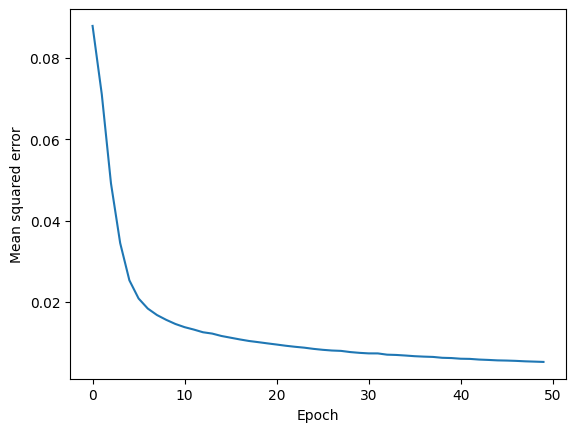

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

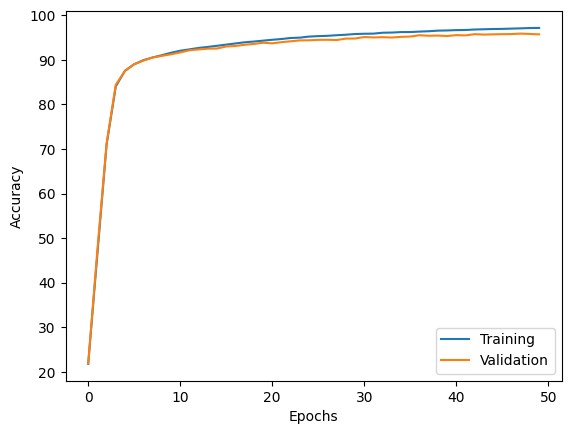

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 95.83%


In [ ]:
# Subset the test dataset
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

# Perform a forward pass through the model
_, _, probas = model.forward(X_test_subset)  # Get the final output (a_out) as probas

# Predicted labels
test_pred = np.argmax(probas, axis=1)

# Find misclassified images
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]


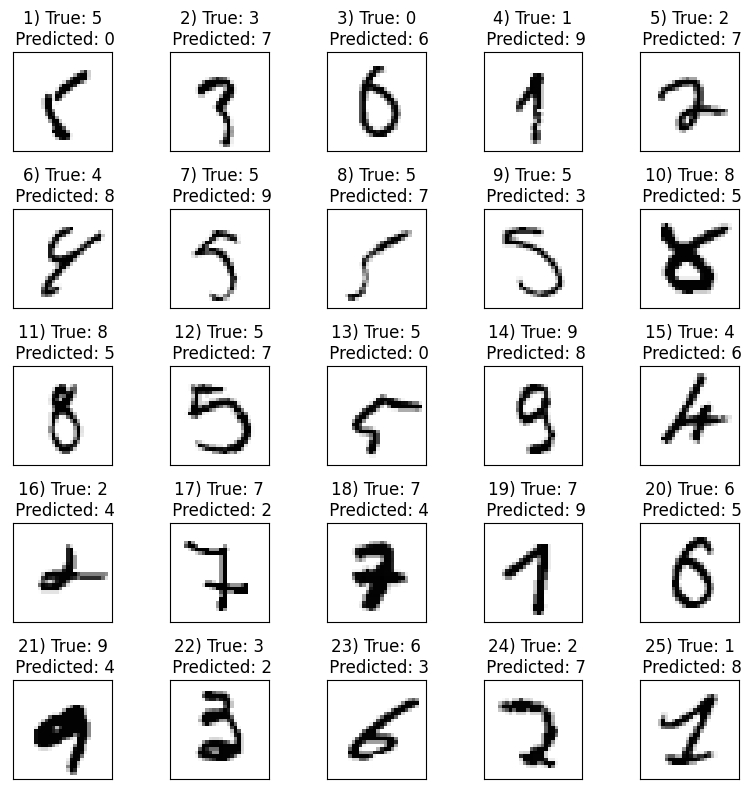

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()